In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from netam import framework, models
from netam.common import pick_device, PositionalEncoding

from shmex.shm_data import train_val_dfs_of_nickname

In [2]:
kmer_length = 3
site_count = 410

train_df, val_df = train_val_dfs_of_nickname('shmoof_small')

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)

device = pick_device()
train_dataset.to(device)
val_dataset.to(device)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

Interpreting shmoof_small as a shmoof dataset
Using Metal Performance Shaders
we have 46391 training examples and 2625 validation examples


In [3]:
class CNNXfModel(models.KmerModel):
    def __init__(self, kmer_length, embedding_dim, num_filters, kernel_size, nhead, dim_feedforward, num_transformer_layers, dropout_prob=0.1):
        super().__init__(kmer_length)
        self.kmer_embedding = nn.Embedding(self.kmer_count, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout=dropout_prob) 
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.transformer_encoder_layer = TransformerEncoderLayer(
            d_model=num_filters,  # This should match the number of filters in the last conv layer
            nhead=nhead,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(self.transformer_encoder_layer, num_layers=num_transformer_layers)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(in_features=num_filters, out_features=1)

    def forward(self, encoded_parents, masks, wt_base_modifier):
        kmer_embeds = self.kmer_embedding(encoded_parents)
        kmer_embeds = self.pos_encoder(kmer_embeds)
        kmer_embeds = kmer_embeds.permute(0, 2, 1)
        conv_out = F.relu(self.conv(kmer_embeds))
        conv_out = self.dropout(conv_out)
        conv_out = conv_out.permute(0, 2, 1)
        transformer_out = self.transformer_encoder(conv_out)
        log_rates = self.linear(transformer_out).squeeze(-1)
        rates = torch.exp(log_rates * masks)

        return rates

model = CNNXfModel(kmer_length=3, embedding_dim=8, num_filters=10, kernel_size=11, nhead=2, dim_feedforward=64, num_transformer_layers=2)

model.to(device)

CNNXfModel(
  (kmer_embedding): Embedding(65, 8)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (conv): Conv1d(8, 10, kernel_size=(11,), stride=(1,), padding=same)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
    )
    (linear1): Linear(in_features=10, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=64, out_features=10, bias=True)
    (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantiz

In [4]:
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.001, min_learning_rate=1e-6, weight_decay=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)

starting training...


Epoch: 100%|██████████| 100/100 [1:45:39<00:00, 63.40s/it, loss_diff=-1.391e-05, lr=1.56e-5, val_loss=0.05608]


In [5]:
losses

,train_loss,val_loss
0,0.064428,0.056909
1,0.063071,0.056741
2,0.062671,0.056629
3,0.062478,0.057040
4,0.062350,0.056421
...,...,...
95,0.061033,0.056071
96,0.061032,0.056069
97,0.061043,0.056073
98,0.061033,0.056091


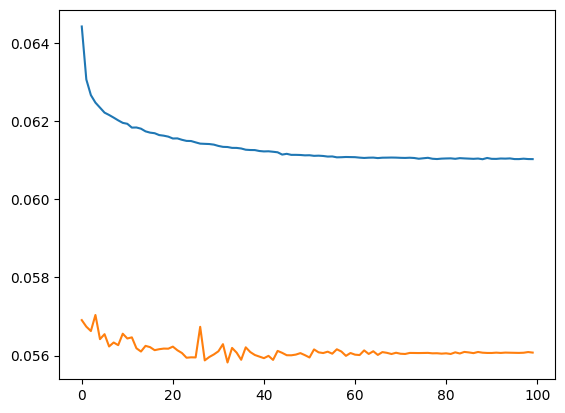

In [7]:
plt.plot(losses['train_loss'], label='train loss')
plt.plot(losses['val_loss'], label='val loss')